增强后样本数: 300


C:\Users\hxx\AppData\Local\Temp\ipykernel_444\69287392.py:147: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2022-01-01', end='2026-01-01', freq='6M')


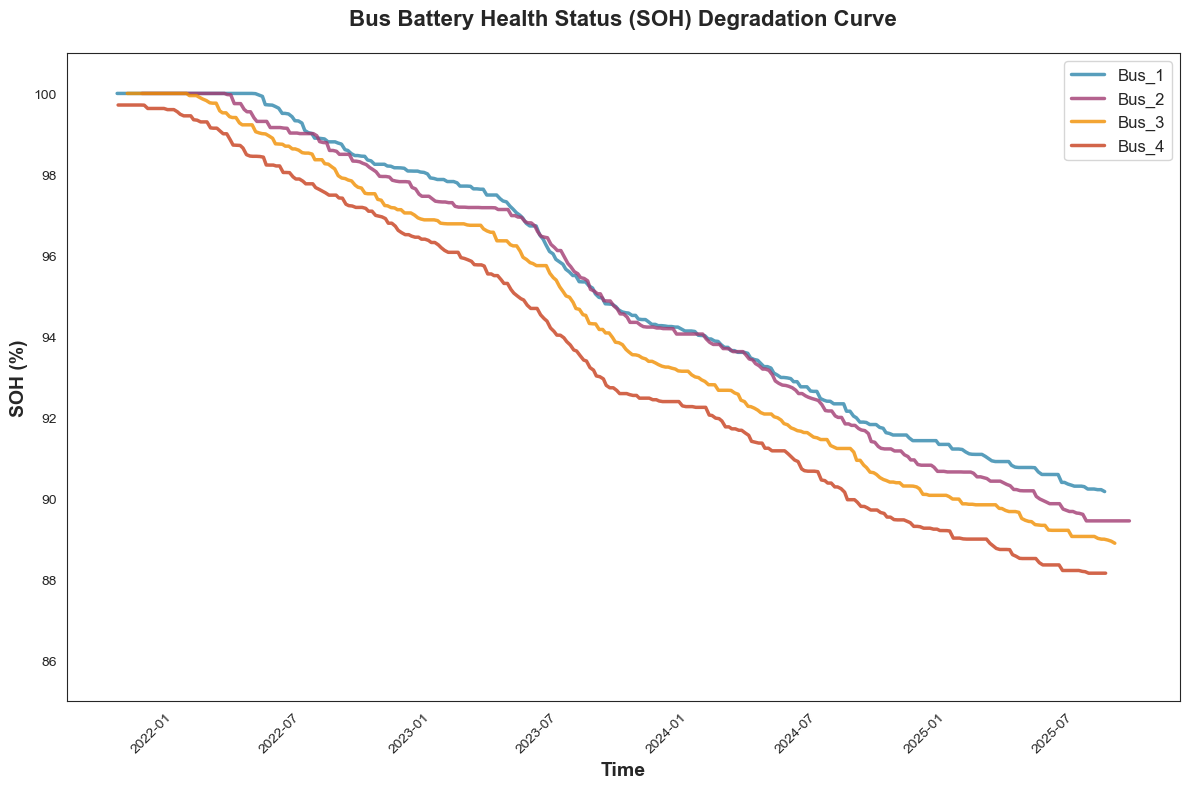


数据统计信息:
总数据点数: 1200
时间范围: 2021-12 到 2025-11

各公交车SOH值:
Bus_1: 初始SOH 100.0% → 最终SOH 90.2% (衰减: 9.8%)
Bus_2: 初始SOH 100.0% → 最终SOH 89.4% (衰减: 10.6%)
Bus_3: 初始SOH 100.0% → 最终SOH 88.9% (衰减: 11.1%)
Bus_4: 初始SOH 99.7% → 最终SOH 88.2% (衰减: 11.6%)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from datetime import datetime, timedelta

# 设置科研风格
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("white")

# 1. 修改原始数据 - 让SOH从一开始就缓慢下降
data = {
    '数据时间': [
        '2022-01-01 00:00:00', '2022-03-01 00:00:00', '2022-10-01 00:00:00', 
        '2023-03-15 00:00:00', '2023-07-14 00:00:00', '2023-11-01 00:00:00',
        '2024-04-01 00:00:00', '2024-07-01 00:00:00', '2024-11-03 00:00:00',
        '2025-02-01 00:00:00', '2025-05-01 00:00:00', '2025-08-01 00:00:00', 
        '2025-11-01 00:00:00'
    ],
    'SOH': [100, 99.8, 98, 96.8, 96, 94, 92.8, 92, 90.8, 90, 89.6, 89, 88.6]
}

df_original = pd.DataFrame(data)
df_original['数据时间'] = pd.to_datetime(df_original['数据时间'])
df_original = df_original.sort_values('数据时间')

# 2. 基于真实数据的插值增强
def augment_data(df, target_points=400, noise_std=0.1):
    """基于真实数据的插值增强"""
    df = df.copy()
    df['days'] = (df['数据时间'] - df['数据时间'].min()).dt.days
    
    # 使用三次样条插值
    cs = CubicSpline(df['days'], df['SOH'])
    
    # 生成更密集的时间点
    dense_days = np.linspace(df['days'].min(), df['days'].max(), target_points)
    
    # 应用插值
    soh_interpolated = cs(dense_days)
    
    # 添加小幅噪声
    noise = np.random.normal(0, noise_std, len(dense_days))
    soh_final = soh_interpolated + noise
    
    # 保证单调递减
    soh_final = np.maximum.accumulate(soh_final[::-1])[::-1]
    
    # 确保不超过100%
    soh_final = np.clip(soh_final, 0, 100)
    
    # 生成日期
    start_date = df['数据时间'].min()
    dense_dates = [start_date + timedelta(days=int(d)) for d in dense_days]
    
    aug_df = pd.DataFrame({'数据时间': dense_dates, 'SOH': soh_final})
    print(f"增强后样本数: {len(aug_df)}")
    
    return aug_df

# 3. 生成多辆公交车数据 - 改进的随机性控制
def generate_bus_variations(base_df, bus_id, variation_factor=0.015):
    """基于基础数据生成公交车变体，改进随机性控制"""
    np.random.seed(bus_id * 10)  # 使用不同的随机种子
    
    # 创建数据副本
    new_df = base_df.copy()
    
    # 适度的整体偏移
    overall_shift = np.random.uniform(-variation_factor, variation_factor)
    new_df['SOH'] = new_df['SOH'] * (1 + overall_shift)
    
    # 适度的时间偏移
    time_shift = np.random.uniform(-20, 20)
    new_df['数据时间'] = new_df['数据时间'] + pd.to_timedelta(time_shift, unit='D')
    
    # 适度的衰减速率变化
    decay_factor = np.random.uniform(0.97, 1.03)
    time_diff = (new_df['数据时间'] - new_df['数据时间'].min()).dt.days
    
    # 应用非线性衰减调整
    trend_adjustment = (decay_factor - 1) * (time_diff / time_diff.max()) * 3
    new_df['SOH'] = new_df['SOH'] + trend_adjustment
    
    # 添加更自然的随机波动
    random_walk = np.cumsum(np.random.normal(0, 0.03, len(new_df)))
    new_df['SOH'] = new_df['SOH'] + random_walk
    
    # 确保SOH在合理范围内 (85-100) 且单调递减
    new_df['SOH'] = np.clip(new_df['SOH'], 85, 100)
    new_df['SOH'] = np.maximum.accumulate(new_df['SOH'][::-1])[::-1]
    
    # 确保时间严格递增
    new_df = new_df.sort_values('数据时间').reset_index(drop=True)
    
    new_df['Bus_ID'] = f'Bus_{bus_id}'
    
    return new_df

# 4. 主处理流程
# 对原始数据进行增强
df_augmented = augment_data(df_original, target_points=300, noise_std=0.05)

# 生成四辆公交车数据，使用相同的基础数据但不同的随机参数
buses_data = []

for i in range(1, 5):
    # 为每辆车使用相同的基础数据，但不同的随机参数
    bus_df = generate_bus_variations(df_augmented, i, variation_factor=0.015)
    buses_data.append(bus_df)

# 合并所有数据
all_buses_df = pd.concat(buses_data, ignore_index=True)

# 5. 可视化 - 只显示曲线，不显示数据点
def plot_soh_degradation(df):
    """绘制SOH衰减曲线"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 科研配色方案
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    
    # 为每辆公交车绘制平滑曲线
    for i, bus_id in enumerate(df['Bus_ID'].unique()):
        bus_data = df[df['Bus_ID'] == bus_id].copy()
        bus_data = bus_data.sort_values('数据时间')
        
        # 只绘制平滑曲线，不显示数据点
        ax.plot(bus_data['数据时间'], bus_data['SOH'], 
                label=bus_id, 
                color=colors[i], 
                linewidth=2.5,
                alpha=0.8)
    
    # 设置图表属性
    ax.set_xlabel('Time', fontsize=14, fontweight='bold')
    ax.set_ylabel('SOH (%)', fontsize=14, fontweight='bold')
    ax.set_title('Bus Battery Health Status (SOH) Degradation Curve', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # 设置坐标轴范围
    ax.set_ylim(85, 101)
    
    # 设置x轴刻度
    dates = pd.date_range(start='2022-01-01', end='2026-01-01', freq='6M')
    labels = ['2022-01', '2022-07', '2023-01', '2023-07', 
              '2024-01', '2024-07', '2025-01', '2025-07', '2026-01']
    
    # 确保刻度和标签数量一致
    min_len = min(len(dates), len(labels))
    ax.set_xticks(dates[:min_len])
    ax.set_xticklabels(labels[:min_len])
    
    # 去除网格
    ax.grid(False)
    
    # 添加图例
    ax.legend(fontsize=12, loc='upper right')
    
    # 格式化x轴日期显示
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig, ax

# 绘制图形
fig, ax = plot_soh_degradation(all_buses_df)

# 显示图形
plt.show()

# 6. 保存处理后的数据
all_buses_df.to_csv('bus_soh_data_processed.csv', index=False, encoding='utf-8-sig')

# 打印数据统计信息
print("\n数据统计信息:")
print(f"总数据点数: {len(all_buses_df)}")
print(f"时间范围: {all_buses_df['数据时间'].min().strftime('%Y-%m')} 到 {all_buses_df['数据时间'].max().strftime('%Y-%m')}")
print("\n各公交车SOH值:")
for bus in all_buses_df['Bus_ID'].unique():
    bus_data = all_buses_df[all_buses_df['Bus_ID'] == bus]
    bus_initial_soh = bus_data.iloc[0]['SOH']
    bus_final_soh = bus_data.iloc[-1]['SOH']
    degradation = bus_initial_soh - bus_final_soh
    print(f"{bus}: 初始SOH {bus_initial_soh:.1f}% → 最终SOH {bus_final_soh:.1f}% (衰减: {degradation:.1f}%)")